<html>
<div>
  <span style="font-family: Poppins; font-size:30px; color: white;"> <br/> University of Tehran <br/> CA5
</div>
<span style="font-family: Poppins; font-size:15pt; color: white; vertical-align: middle;"> Mahdi Noori </span><br>
<span style="font-family: Poppins; font-size:15pt; color: white; vertical-align: middle;"> 810100231 </span>

</html>

## Goal
In this notebook we learn CNN models and how to use it for type of tumor based on the MRI picture of the patient brain.

## Problem Description
In this problem we are given several pictures of brain MRI which has been categorized to four classes (`glioma`, `meningioma`, `notumor` and `pituitary`). Using this dataset we are to train a CNN model to predict wethear a patient has some kind of tumor or not based on new data (MRI scans) provided.

## Imports

In [25]:
import numpy as np
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.image as mpimg
import os
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
import seaborn as sns

## Consts

In [26]:
DATASET_PATH = '/content/AI-CA5-Dataset'
CLASS_LABELS = {'glioma':0, 'meningioma':1, 'notumor':2, 'pituitary':3}
EPOCHS = 30

# PreProcessing

Here we define our custom dataset class which inherits `pytorch`'s `Dataset` class. since we are using inheritance we should implement the base functions `__init__`, `__len__` and `__getitem__`.

In [27]:
class MRIDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels

        if transform is None:
            self.transform = transform.Compose([transforms.ToTensor()])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):

        label = self.labels[index]

        sample = Image.open(self.paths[index]).convert(mode="RGB")
        sample = self.transform(sample)

        return (sample,torch.tensor(label, dtype=torch.float))

Now to resize the dataset to 512 by 512 we define the transform below:

In [28]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

### Normalization of pixel values

Normalization of pixel values in an image ensures that the pixel values are adjusted to a common scale, typically between 0 and 1 or -1 and 1, depending on the normalization method used.

`Pros`:
1. **Improved convergence**: Normalizing pixel values can help improve the convergence speed and stability of machine learning algorithms.
2. **Enhanced performance**: It can help models better capture patterns and relationships in the data by reducing the influence of irrelevant variations in pixel intensity.
3. **Mitigation of lighting conditions**: Normalization can help mitigate the effects of different lighting conditions in images.
4. **Compatibility with certain algorithms**: Some machine learning algorithms, such as neural networks, perform better when the input data is normalized.

`Cons`:
1. **Information loss**: Normalization can lead to a loss of information if not performed carefully. For example, if the normalization range is too narrow, the differences between pixel values might be compressed, resulting in a loss of detail.
2. **Sensitivity to outliers**: Normalization can be sensitive to outliers or extreme values in the data.
3. **Task-specific considerations**: The choice of normalization method might depend on the specific computer vision task.

Here for improving our CNN model performance we use Normalization. Note that using the `transforms.ToTensor()` we can normalize the pixel values.

### Data Split
Here we divide the each type of brain MRI to a $80 \% $ and $20 \% $ part.
The reason we are using this ratio is to have enough data for train and enough data for each class so we have a relatively fair data for train.

In [29]:
image_pathes_train = np.array([])
labels_train = np.array([])

image_pathes_test = np.array([])
labels_test = np.array([])

for label in os.listdir(DATASET_PATH):
    files = glob.glob(f"{DATASET_PATH}/{label}/*.jpg")

    X_train, X_test, y_train, y_test = train_test_split(np.array(files), np.array([CLASS_LABELS[label]]*len(files)), test_size=0.2, random_state=42)

    if len(image_pathes_train)==0 and len(image_pathes_test)==0:
        image_pathes_train = X_train
        image_pathes_test = X_test
        labels_train = y_train
        labels_test = y_test
    else:
        image_pathes_train = np.concatenate((image_pathes_train,X_train),axis=0)
        image_pathes_test = np.concatenate((image_pathes_test,X_test),axis=0)
        labels_train = np.concatenate((labels_train,y_train),axis=0)
        labels_test = np.concatenate((labels_test,y_test),axis=0)


### Visualization

In [30]:
def plot_count_bar_chart(data, class_map, title):
    unique_elements, counts = np.unique(data, return_counts=True)
    classes = list(class_map.keys())
    unique_classes = []
    for i in range(len(unique_elements)):
        unique_classes.append(classes[unique_elements[i]])
    plt.bar(unique_classes, counts)

    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Count of Elements in {title} data')

    plt.show()

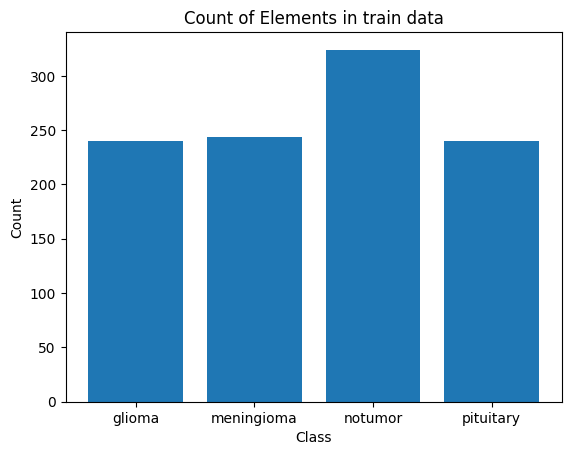

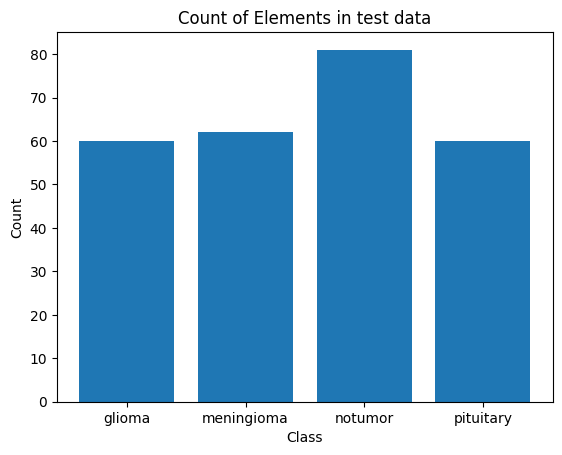

In [31]:
plot_count_bar_chart(labels_train,CLASS_LABELS,"train")
plot_count_bar_chart(labels_test,CLASS_LABELS,"test")

In [32]:
def plot_class_images(dataset_path):
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))

    for i, label in enumerate(os.listdir(dataset_path)):
        files = glob.glob(f"{dataset_path}/{label}/*.jpg")
        img = mpimg.imread(files[0])
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].text(0.5, -0.1, label, transform=axs[i].transAxes,
                    fontsize=10, ha='center')

    plt.subplots_adjust(wspace=0.05)
    plt.show()

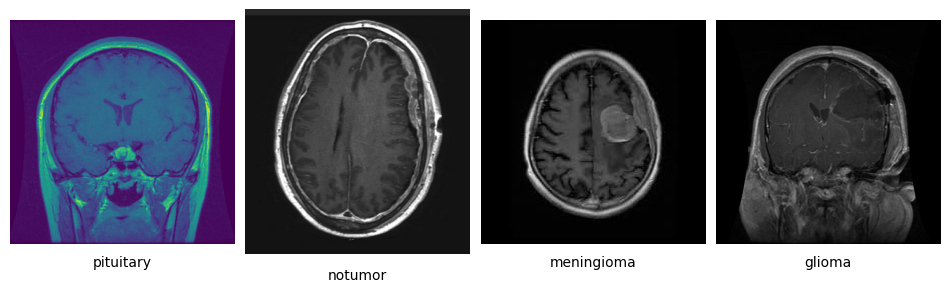

In [33]:
plot_class_images(DATASET_PATH)

# Classification Using CNN

### CNN Architecture

First lets review the parameters :

- `kernel size :`<br>
It refers to the dimensions of the filter used in the convolutional layer. The kernel is a small matrix of weights that is convolved with the input data to extract features.<br>
A smaller kernel size captures local patterns and details, while a larger kernel size captures more global information. For example a 3x3 kernel is commonly used to capture local features. On the other hand, a larger kernel like 5x5 or 7x7 can capture larger structures.<br>
The kernel size affects the receptive field of a neuron in a convolutional layer. A larger kernel size increases the receptive field, allowing the neuron to consider a wider context. However, it also leads to a higher number of parameters and increased computational cost.

- `stride :` <br>
It refers to the step size with which the convolutional kernel moves across the input data during the convolution operation.<br>
By adjusting the stride, we control the spatial resolution of the output feature maps. A larger stride leads to a reduction in spatial dimensions, while a smaller stride preserves more spatial information.

- `padding :`<br>
It refers to the technique of adding extra border pixels to the input data before applying the convolution operation.<br>
Padding can be implemented in two ways:<br>
- 1. Valid padding : In this case, no padding is added, and the convolution operation is performed only on the valid positions of the input.
- 2. Same padding : Same padding ensures that the output feature map has the same spatial dimensions as the input. It achieves this by adding padding such that the convolutional operation covers the entire spatial extent of the input.

- `number of filters :`<br>
It refers to the number of learnable convolutional filters applied to the input data during the convolutional layers. Each filter specializes in detecting specific features in the input.<br>
Increasing the number of filters allows the network to learn a more diverse set of features. Each filter learns to detect different types of local patterns.<br>
However, increasing the number of filters also increases the computational cost and the number of parameters in the network which can lead to overfitting.

- `depth of the network :`<br>
It refers to the number of layers in the network.<br>
Increasing the depth of a network allows it to learn more complex and abstract representations of the input data.<br>
However, deeper networks also pose challenges such as vanishing gradients and increased computational cost.

- `activation functions :`<br>
They introduce non-linearity to the network, enabling it to learn complex relationships and make accurate predictions. Here are a few commonly used activation functions:<br>

1. **ReLU :** It is defined as $f(x) = max(0, x)$. It is computationally efficient and helps with faster convergence during training. However, ReLU can suffer from the "dying ReLU" problem, where neurons can become non-responsive and output zero for all inputs.
2. **Leaky ReLU :** Leaky ReLU is an extension of ReLU that addresses the dying ReLU problem. It introduces a small non-zero slope for negative values. The function is defined as $f(x) = max(ax, x)$ where a is a small constant typically set to a very small value like 0.01.

3. **Sigmoid :** The sigmoid activation function is defined as $f(x) = 1 / (1 + e^{-x})$. It squashes the input into the range of (0, 1), making it suitable for binary classification problems. However, sigmoid functions can suffer from the vanishing gradient problem when dealing with deep networks.

4. **Tanh :** Tanh is similar to the sigmoid function but is centered around zero and ranges from -1 to 1. It is defined as $f(x) = (e^{x} - e^{-x}) / (e^{x} + e^{-x})$. Tanh activations are commonly used in CNNs when the output needs to be normalized within a specific range.

5. **Softmax :** Softmax is often used in the output layer of a network for multi-class classification tasks. It converts a vector of real numbers into a probability distribution, where the output values sum up to 1.

- `number of neurons :`<br>
It determines the number of learnable parameters and the capacity of the network to represent complex relationships in the data.<br>
The important note here is that as we increase the neurons in a layer the model can predict better but it may result in a overfitting problem.<br>
However, a low number may result in underfitting.

The model we are using here is inspired by `AlexNet`. For an explaination we first increase the number of filters in each convolutional layer to capture more and more details.

- Convolutional Layer 1: It extracts low-level features such as edges, corners, and textures. The layer applies filters of size 11x11 with a stride of 4.

- Convolutional Layer 2: It captures more complex and higher-level features.

- Convolutional Layer 3: This layer uses filters of size 3x3 to further extract more abstract features from the previous layer's output.

- Convolutional Layer 4: It applies filters of size 3x3 to the feature maps produced by the third convolutional layer. Like the previous layers, it enhances the network's ability to capture complex patterns. it also add an stability to the model.

- Convolutional Layer 5: This layer consists of filters of size 3x3. It extracts even higher-level features from the previous layer's output.

- Fully Connected Layers: The last three layers of AlexNet are fully connected layers. They are responsible for learning high-level representations and making predictions. The first fully connected layer consists of 4096 neurons. The second fully connected layer also has 4096 neurons to enhance and stabalize the model, and the final fully connected layer outputs the class probabilities, representing the predicted labels.

- Max Pooling Layers: Max pooling layer is applied to reduce the spatial dimensions of the feature maps.

- Average Polling Layer: Applied to reduce the spatial dimensions so it becomes easier for the model to do the `Flatten` action as it might be a bottleneck.

- Activation Functions: Here we use ReLU as our main activation as it is a simple function that has low computational cost and does not add any extra complexity to the model.

In [34]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Loss Function

1. `Mean Squared Error Loss`:
Calculates the mean squared difference between the input and target tensors.<br>
Used for regression tasks where the goal is to minimize the mean squared difference between the predicted and target values.

 $$MSE = \frac{1}{n} \sum_{i=1}^{n} ( predicted_i - target_i )^2$$

2. `Binary Cross-Entropy Loss`:
Computes the binary cross-entropy loss between input and target tensors.<br>
Suitable for binary classification problems.
$$BCE = - \left( target* \log(predicted) + (1 - target) \log(1 - predicted) \right)$$


3. `Binary Cross-Entropy Loss with Logits`:
Combines a sigmoid activation function and binary cross-entropy loss into a single efficient computation.<br>
Similar to binary cross-entropy loss, but more numerically stable when dealing with unbounded logits.
$$BCEWithLogits = \max(logits, 0) - logits \cdot target + \log(1 + \exp(-|logits|))$$


4. `Categorical Cross-Entropy Loss`:
Computes the cross-entropy loss between the input and target tensors for multi-class classification problems.<br>
Commonly used for multi-class classification problems.
 $$CrossEntropy = - \sum_{i=1}^{C} target_i \log(predicted_i)$$

5. `Negative Log-Likelihood Loss`:
Computes the negative log-likelihood loss for multi-class classification problems.<br>
Suitable for multi-class classification problems where the targets are class labels.
$$NLLLoss = - \log(predicted_{target})$$

Here as we are solving a multiclass classification problem we choose `Categorical Cross-Entropy Loss`. The other reason here is that it is a widely used loss function in CNN problems. we can also mention that it enables the abillity to backpropagate as it uses a smooth and differentiable loss function.

In [35]:
loss_function = nn.CrossEntropyLoss()

### Optimizer

The Adam optimizer combines the concepts of momentum and adaptive learning rates to efficiently update the model's parameters during training. The primary goal of Adam is to find the optimal values of the model's parameters that minimize the loss function.

`This is how it works :`<br>
Adam initializes the first and second moments' variables, m and v to zero. These variables keep track of the exponentially decaying average of past gradients and the exponentially decaying average of past squared gradients.<br>
The gradients of the model's parameters with respect to the loss function are computed using backpropagation.<br>
The first moment, m, is updated by exponentially decaying averages of the gradients. The second moment, v, is updated by exponentially decaying averages of the squared gradients. The decay rates are controlled by the hyperparameters beta1 and beta2, respectively.<br>
Since the moments m and v are initialized as zero, they are biased towards zero, particularly in the first few iterations. To counteract this bias, Adam performs bias correction by dividing the moments by factors of 1 - beta1 and 1 - beta2, respectively.<br>
Finally, Adam updates the model's parameters using the calculated moments and the learning rate. The learning rate is multiplied by the square root of the bias-corrected v, and the resulting value is divided by the biased-corrected m. This update rule allows for adaptive learning rates for each parameter.

`Differences from SGD :`<br>
- Adaptive learning rate:<br> SGD, which uses a fixed learning rate for all parameters, wheras Adam adapts the learning rate for each parameter. This adaptiveness can speed up convergence and improve overall performance.

- Momentum:<br> Adam combines adaptive learning rates with momentum-like behavior using the first moment, m. This combination enables Adam to converge faster and handle sparse gradients effectively.

- Additional hyperparameters:<br> Adam introduces two hyperparameters, beta1 and beta2, which control the decay rates of the first and second moments. These hyperparameters need to be fine-tuned to achieve optimal performance.

As we are aiming for a fast and reliable convergence we use Adam optimizer.

In [36]:
model = CNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train The Model

The batch size in a `DataLoader` is the number of samples in each batch of data that is loaded and processed together during training or inference. It determines how many samples are passed through the network in one forward and backward pass.<br><br>
The batch size can have several effects:

`Memory Usage`: <br>The batch size determines how many samples are loaded into memory at a time. Larger batch sizes require more memory because the model needs to store the activations and gradients. If the batch size is too large for the available memory, it can lead to out-of-memory errors. On the other hand, smaller batch sizes require less memory but may result in slower training.

`Training Speed`:<br> The batch size affects the training speed. Larger batch sizes can utilize parallel processing more efficiently, especially when training on GPUs, because multiple samples can be processed simultaneously.

`Generalization`: <br>Smaller batch sizes provide more randomization which can help the model generalize better to unseen data. larger batch sizes may provide smoother gradients and lead to more accurate updates of model parameters.


In [37]:
train_dataset = MRIDataset(image_pathes_train,labels_train,transform)
test_dataset = MRIDataset(image_pathes_test,labels_test,transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [38]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
  correct_train = 0
  total_train = 0
  running_loss = 0.0
  for i,(inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      outputs = model(inputs)

    _, predicted = torch.max(outputs.data, 1)
    total_train += labels.size(0)
    correct_train += (predicted == labels).sum().item()

    error = loss_function(outputs, labels.to(torch.long))
    running_loss += error.item()
    error.backward()
    optimizer.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

  train_accuracies.append(100 * correct_train / total_train)
  train_losses.append(running_loss / total_train)
  print(f'--------- Epoch {epoch+1}')
  print(f'The train accuracy is : {(100 * correct_train / total_train):.2f} %')
  print(f'The train loss is : {(running_loss / total_train):.4f}')

  correct_test = 0
  total_test = 0
  running_loss = 0.0

  with torch.no_grad():
    for i,(inputs, labels) in enumerate(test_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total_test += labels.size(0)
      correct_test += (predicted == labels).sum().item()

      error = loss_function(outputs, labels.to(torch.long))
      running_loss += error.item()

      del inputs, labels, outputs


  test_accuracies.append(100 * correct_test / total_test)
  test_losses.append(running_loss / total_test)
  print(f'The test accuracy is : {(100 * correct_test / total_test):.2f} %')
  print(f'The test loss is : {(running_loss / total_test):.4f}')

--------- Epoch 1
The train accuracy is : 32.25 %
The train loss is : 0.0871
The test accuracy is : 47.53 %
The test loss is : 0.0727
--------- Epoch 2
The train accuracy is : 46.85 %
The train loss is : 0.0709
The test accuracy is : 46.01 %
The test loss is : 0.0674
--------- Epoch 3
The train accuracy is : 53.72 %
The train loss is : 0.0644
The test accuracy is : 69.20 %
The test loss is : 0.0516
--------- Epoch 4
The train accuracy is : 69.27 %
The train loss is : 0.0453
The test accuracy is : 74.14 %
The test loss is : 0.0428
--------- Epoch 5
The train accuracy is : 71.95 %
The train loss is : 0.0396
The test accuracy is : 72.24 %
The test loss is : 0.0480
--------- Epoch 6
The train accuracy is : 73.57 %
The train loss is : 0.0365
The test accuracy is : 73.38 %
The test loss is : 0.0430
--------- Epoch 7
The train accuracy is : 75.95 %
The train loss is : 0.0325
The test accuracy is : 74.14 %
The test loss is : 0.0469
--------- Epoch 8
The train accuracy is : 77.58 %
The train lo

Now we plot the accuracy and loss in each epoch

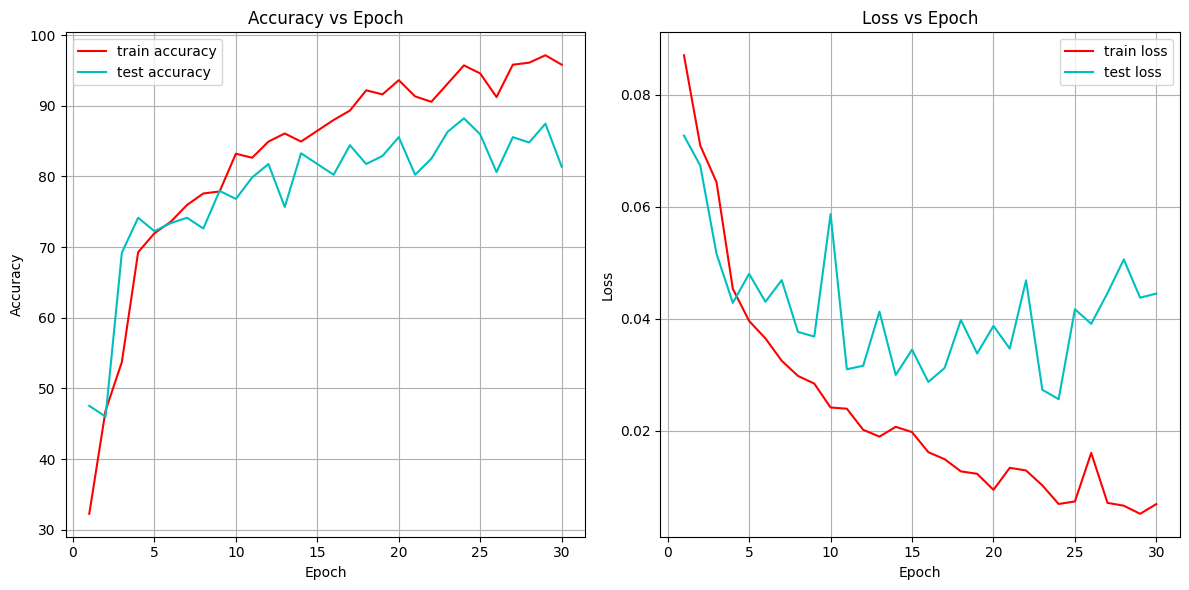

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(range(1,EPOCHS+1), train_accuracies, label="train accuracy",color="r")
axs[0].plot(range(1,EPOCHS+1), test_accuracies, label="test accuracy",color="c")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs Epoch')
axs[0].legend()
axs[0].grid()



axs[1].plot(range(1,EPOCHS+1), train_losses, label="train loss",color="r")
axs[1].plot(range(1,EPOCHS+1), test_losses, label="test loss",color="c")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss vs Epoch')

axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

In [40]:
del model

### Regularization

**Batch Normalization:**

Batch Normalization (BN) is a technique that normalizes the activations of each layer in a neural network by adjusting and scaling them.

The process of normalization in this method is:

1. Compute the mean and variance of the activations in the mini-batch.
2. Normalize the activations by subtracting the mean and dividing by the standard deviation.
3. Scale and shift the normalized activations by learnable parameters called gamma and beta, respectively.

The main benefits are:

`Improving network training speed:`<br> By normalizing the inputs, it helps to stabilize and speed up the convergence of the network.

`Reducing sensitivity to the initialization:`<br> Batch Normalization reduces the dependence of the network on the initial parameter values.

`Regularization effect:`<br> It adds a regularization effect and reduces overfitting to some extent.

**Dropout:**

Dropout is a regularization technique that randomly sets a fraction of input units (neurons) to zero during the forward pass of training. This means that the selected neurons are "dropped out" or temporarily removed from the network. This act happens based on a probability.

The process of this method is:

During training, the dropout process is applied independently to each training example in each forward pass. In each pass, a new network is created by randomly dropping out neurons, and the gradients are backpropagated only through the active neurons. During inference or testing, the entire network is used, but the weights of the neurons are scaled by the dropout rate to account for the fact that more neurons are active during inference than during training.

The main benefits are:

`Regularization:` <br>Dropout acts as a form of regularization and It helps to reduce overfitting and makes the network more robust.

`Improving generalization:` <br>By randomly dropping out neurons, Dropout forces the network to learn redundant representations and prevents it from relying too heavily on specific features aiming for a more generalized network.

For `batch size` parameter we should pick th count of filters of a the Linear layer behind it.
Now for `drop` probability having a high probability may result in underfitting as it can lead to reduced capacity of the model to learn and capture complex patterns in the data.
On the other hand with a low probability we can not perform the regularization well and in some cases it may result in overfitting. So i picked $0.2$ as the probability.

In [41]:
class CNNModelWithReg(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModelWithReg, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModelWithReg().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
  correct_train = 0
  total_train = 0
  running_loss = 0.0
  for i,(inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      outputs = model(inputs)

    _, predicted = torch.max(outputs.data, 1)
    total_train += labels.size(0)
    correct_train += (predicted == labels).sum().item()

    error = loss_function(outputs, labels.to(torch.long))
    running_loss += error.item()
    error.backward()
    optimizer.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

  train_accuracies.append(100 * correct_train / total_train)
  train_losses.append(running_loss / total_train)
  print(f'--------- Epoch {epoch+1}')
  print(f'The train accuracy is : {(100 * correct_train / total_train):.2f} %')
  print(f'The train loss is : {(running_loss / total_train):.4f}')

  correct_test = 0
  total_test = 0
  running_loss = 0.0

  with torch.no_grad():
    for i,(inputs, labels) in enumerate(test_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total_test += labels.size(0)
      correct_test += (predicted == labels).sum().item()

      error = loss_function(outputs, labels.to(torch.long))
      running_loss += error.item()

      del inputs, labels, outputs


  test_accuracies.append(100 * correct_test / total_test)
  test_losses.append(running_loss / total_test)
  print(f'The test accuracy is : {(100 * correct_test / total_test):.2f} %')
  print(f'The test loss is : {(running_loss / total_test):.4f}')

--------- Epoch 1
The train accuracy is : 27.77 %
The train loss is : 0.0882
The test accuracy is : 30.80 %
The test loss is : 0.0894
--------- Epoch 2
The train accuracy is : 35.11 %
The train loss is : 0.0853
The test accuracy is : 39.92 %
The test loss is : 0.0886
--------- Epoch 3
The train accuracy is : 45.23 %
The train loss is : 0.0760
The test accuracy is : 43.73 %
The test loss is : 0.0791
--------- Epoch 4
The train accuracy is : 48.57 %
The train loss is : 0.0693
The test accuracy is : 49.81 %
The test loss is : 0.0683
--------- Epoch 5
The train accuracy is : 53.53 %
The train loss is : 0.0650
The test accuracy is : 51.71 %
The test loss is : 0.0672
--------- Epoch 6
The train accuracy is : 55.73 %
The train loss is : 0.0619
The test accuracy is : 55.51 %
The test loss is : 0.0640
--------- Epoch 7
The train accuracy is : 62.69 %
The train loss is : 0.0555
The test accuracy is : 61.98 %
The test loss is : 0.0578
--------- Epoch 8
The train accuracy is : 67.56 %
The train lo

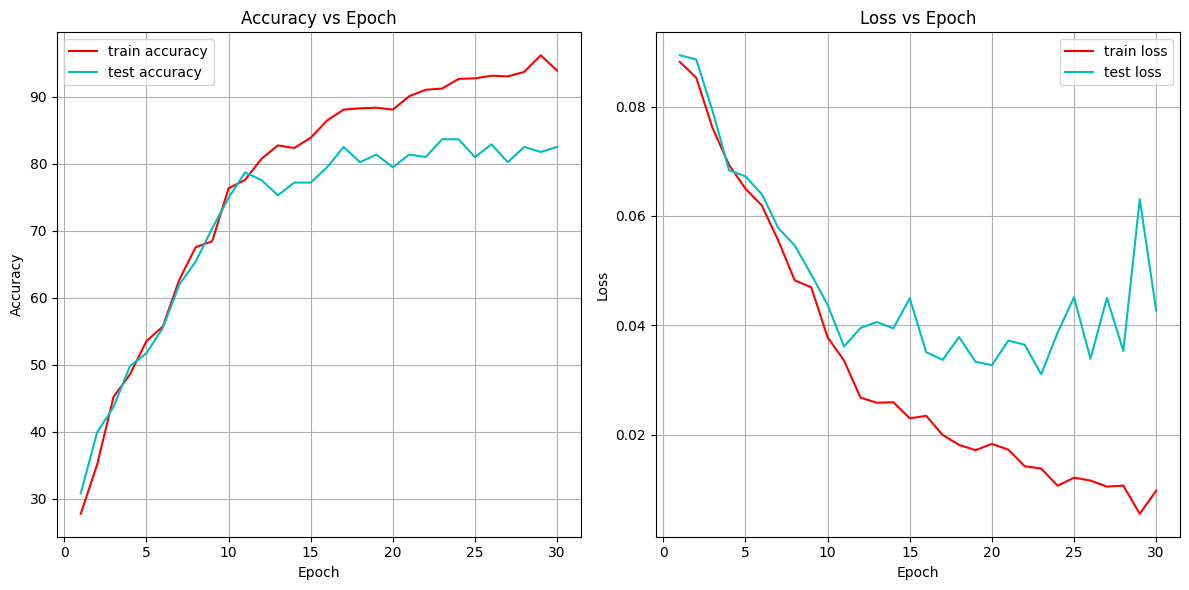

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(range(1,EPOCHS+1), train_accuracies, label="train accuracy",color="r")
axs[0].plot(range(1,EPOCHS+1), test_accuracies, label="test accuracy",color="c")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs Epoch')
axs[0].legend()
axs[0].grid()



axs[1].plot(range(1,EPOCHS+1), train_losses, label="train loss",color="r")
axs[1].plot(range(1,EPOCHS+1), test_losses, label="test loss",color="c")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss vs Epoch')

axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

As you can see by adding the regularization factor the overfitting is becoming less and less. The model already performed good without regularization but after adding it the accuracies have became closer.<br>
The important thing to notice here is that by adding `BatchNorm2d` the model performance after testing was not that well because of presenting more noise and just the `Dropout` has done the job.

# Evaluation and Analysis

In [45]:
def calc_metrics(y, y_pred, class_map):
    y = np.array(y)
    y_pred = np.array(y_pred)
    print(f"Accuracy of the model is {sk_metrics.accuracy_score(y, y_pred)*100.0:.2f} %")
    print(f"Precision of the model is {sk_metrics.precision_score(y, y_pred, average='macro')*100.0:.2f} %")
    print(f"Recall of the model is {sk_metrics.recall_score(y, y_pred, average='macro')*100.0:.2f} %")
    print(f"F1_score of the model is {sk_metrics.f1_score(y, y_pred, average='macro')*100.0:.2f} %\n")

    for key,val in class_map.items():
        y_copy = []
        y_pred_copy = []
        for i in range(len(y)):
            y_pred_copy.append(1 if y_pred[i] == val else 0)
            y_copy.append(1 if y[i] == val else 0)
        y_copy = np.array(y_copy)
        y_pred_copy = np.array(y_pred_copy)

        print(f"Accuracy for type {key} is {sk_metrics.accuracy_score(y_copy, y_pred_copy)*100.0:.2f} %")
        print(f"Precision for type {key} is {sk_metrics.precision_score(y_copy, y_pred_copy)*100.0:.2f} %")
        print(f"Recall for type {key} is {sk_metrics.recall_score(y_copy, y_pred_copy)*100.0:.2f} %")
        print(f"F1_score for type {key} is {sk_metrics.f1_score(y_copy, y_pred_copy)*100.0:.2f} %\n")

    cm = sk_metrics.confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_map.keys(), yticklabels=class_map.keys())

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(class_map.keys())) + 0.5, class_map.keys())
    plt.yticks(np.arange(len(class_map.keys())) + 0.5, class_map.keys())
    plt.show()


Accuracy of the model is 85.93 %
Precision of the model is 85.60 %
Recall of the model is 85.47 %
F1_score of the model is 85.30 %

Accuracy for type glioma is 94.68 %
Precision for type glioma is 92.59 %
Recall for type glioma is 83.33 %
F1_score for type glioma is 87.72 %

Accuracy for type meningioma is 87.45 %
Precision for type meningioma is 74.58 %
Recall for type meningioma is 70.97 %
F1_score for type meningioma is 72.73 %

Accuracy for type notumor is 96.20 %
Precision for type notumor is 94.94 %
Recall for type notumor is 92.59 %
F1_score for type notumor is 93.75 %

Accuracy for type pituitary is 93.54 %
Precision for type pituitary is 80.28 %
Recall for type pituitary is 95.00 %
F1_score for type pituitary is 87.02 %



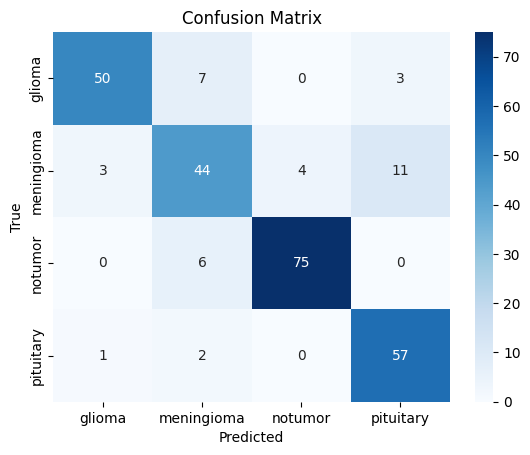

In [46]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for i,(inputs, labels) in enumerate(test_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      temp_y_true = [x.item() for x in list(labels)]
      temp_y_pred = [x.item() for x in list(predicted)]
      y_true += temp_y_true
      y_pred += temp_y_pred

calc_metrics(np.array(y_true),np.array(y_pred),CLASS_LABELS)

As it is obvious the model performs pretty well on `notumor` and `piturity` but on the two other classes it does not perform as well as these two. To address this problem we can add more data for these classes or manipulate the ones we have to get a better performance.

# Conclusion
In conclusion, Convolutional Neural Networks (CNNs) have proven to be highly effective in image classification. They excel at extracting meaningful features from images and have achieved remarkable performance in various domains. CNNs automatically learn relevant features from data, eliminating the need for manual feature engineering. They can handle large-scale datasets efficiently and have revolutionized computer vision.